# ITCS 4156 - Programming Assignment 1-  Linear Regression


<font color="blue"> James Cowell_801101165 </font>

# Instructions

In this programming assignment you will be training **four** kinds of models to predict house prices from the given features. The four models are:

1. Linear regression with one variable using least squared method.
2. Linear regression with multiple variables using least mean squares method and batch training.
3. Polynomial regression with one variable.
4. Polynomial regression with multiple variables and regularization.

You will code in the files provided with this assignment and use this notebook as a tool to train, test and visualize your results.

Lookout for **TODO** tags - they tell you what needs to be done.

In [1]:
# This ensures that whenever you make edits in your code files, your changes will get reflected 
# in this notebook as soon you run the cell which imports the method/class from the said code file.

%load_ext autoreload
%autoreload 2

# Data

The dataset consists of 3 splits: train, val and test. 

1. **Train**: Throughout this assignment you will be training your model using this data.
2. **Val**: You will then use this to tune your model and evaluate its performance.
3. **Test**: This split simulates real life data which we often dont have access to until the model is deployed. We have kept this split hidden from you and we will use it to judge the performance of your model.

Training and validation data will be downloaded to your machine as you execute the following lines of code.

In [2]:
from itcs4156.datasets.HousingDataset import HousingDataset
dataset = HousingDataset()

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\housing.train

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\housing.val

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\housing.names



Lets take a moment to understand what this dataset is about

In [3]:
with open(dataset.data["paths"]["names"], 'r') as rf:
    print(rf.read())

1. Title: Housing Data

2. Concerns housing values in suburbs of Boston.

3. Number of Attributes: 13 continuous attributes (including "class"
                         attribute "MEDV"), 1 binary-valued attribute.

4. Attribute Information:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per $10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B     

In [4]:
# This loads our training and validation dataset into two pandas dataframes
df_train, df_val = dataset.load()

In [5]:
# The head method lists top 5 rows in the dataframe
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.01360,75.0,4.00,0,0.410,5.888,47.6,7.3197,3,469.0,21.1,396.90,14.80,18.9
1,0.77299,0.0,8.14,0,0.538,6.495,94.4,4.4547,4,307.0,21.0,387.94,12.80,18.4
2,7.05042,0.0,18.10,0,0.614,6.103,85.1,2.0218,24,666.0,20.2,2.52,23.29,13.4
3,0.20608,22.0,5.86,0,0.431,5.593,76.5,7.9549,7,330.0,19.1,372.49,12.50,17.6
4,0.10084,0.0,10.01,0,0.547,6.715,81.6,2.6775,6,432.0,17.8,395.59,10.16,22.8


# Visualize
Lets see how each of these variables affect the housing price

In [6]:
import matplotlib.pyplot as plt

def plot_features_vs_price(df, features):
    n = len(features)
    cols = 4
    rows = n / cols if n%cols == 0 else (n//cols + 1)
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(n):
        ax = fig.add_subplot(rows, cols, i+1)
        Y = df["MEDV"].values
        X = df[features[i]].values
        ax.scatter(X,Y, marker='x')
        ax.set_xlabel(features[i])
        ax.set_ylabel("MEDV")

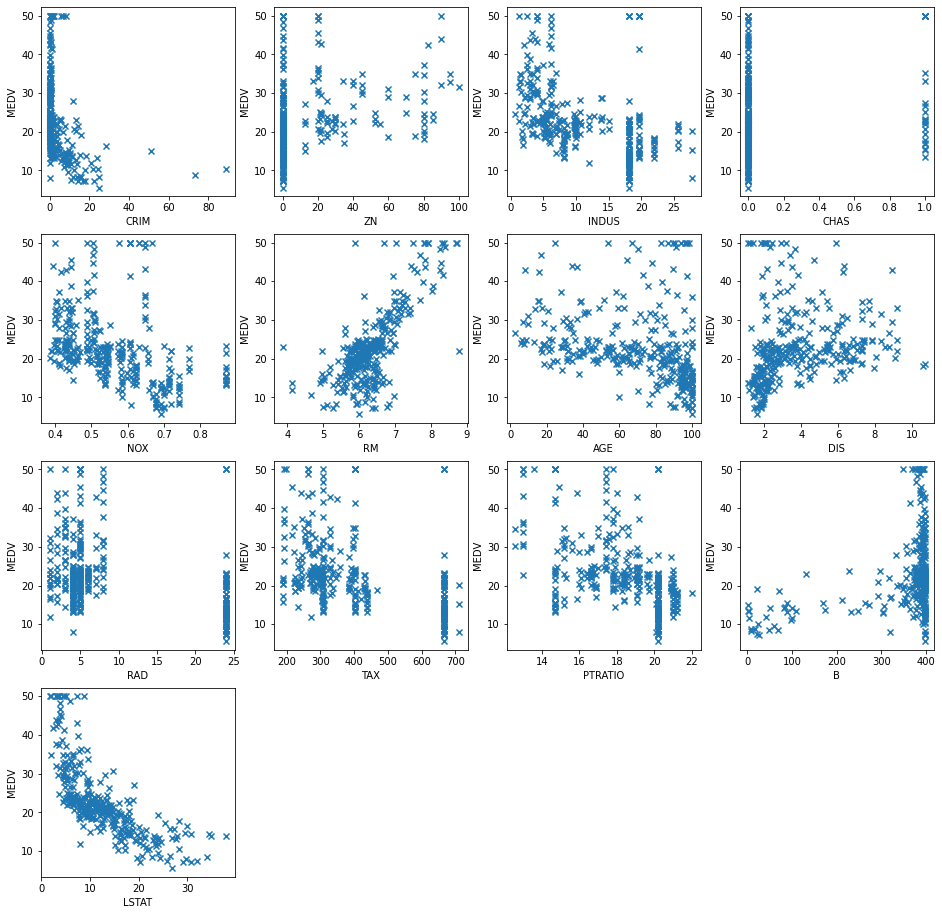

In [7]:
plot_features_vs_price(df_train, df_train.columns[:-1])

# Preprocessing
Before we begin training our models using this dataset, we will normalize our dataset.


In [8]:
from itcs4156.util.data import mean_normalize

df_train, mean, std = mean_normalize(df_train)
df_val, _, _ = mean_normalize(df_val, mean, std)

df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.405706,2.690785,-1.016879,-0.282876,-1.241728,-0.587438,-0.759840,1.664061,-0.715564,0.415033,1.246471,0.446276,0.321505,-0.407123
1,-0.317117,-0.490798,-0.422801,-0.282876,-0.161083,0.241263,0.913267,0.318594,-0.597822,-0.570715,1.201841,0.352425,0.041879,-0.459506
2,0.415198,-0.490798,1.006430,-0.282876,0.480551,-0.293911,0.580791,-0.823949,1.757014,1.613750,0.844798,-3.684635,1.508516,-0.983330
3,-0.383251,0.442466,-0.749975,-0.282876,-1.064435,-0.990183,0.273339,1.962365,-0.244597,-0.430763,0.353865,0.190595,-0.000065,-0.543318
4,-0.395528,-0.490798,-0.154462,-0.282876,-0.085100,0.541616,0.455665,-0.516018,-0.362339,0.189893,-0.226330,0.432555,-0.327227,0.001460


# Models

## Linear Regression with One Variable

In this first task, the challenge is to learn a linear realtionship between **number of rooms in the house vs the price of the house.** 

In [9]:
from itcs4156.util.data import get_input_output

X_tr, Y_tr = get_input_output(df_train, in_features="RM", out_feature="MEDV")
X_val, Y_val = get_input_output(df_val, in_features="RM", out_feature="MEDV")

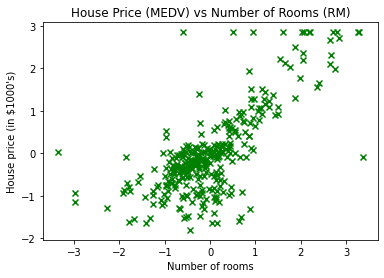

In [10]:
def plot_price_vs_rooms(X,Y):
    fig = plt.figure()
    plt.scatter(X, Y, marker='x', color='g')
    plt.xlabel("Number of rooms")
    plt.ylabel("House price (in $1000's)")
    plt.title("House Price (MEDV) vs Number of Rooms (RM)")
plot_price_vs_rooms(X_tr,Y_tr)


###  ====  TODO - 1 ====
Fill in the code for **LeastSquares** class provided with this assignment and use it train a model for predicting house prices based on number of rooms.

In [11]:
from itcs4156.assignments.regression.LeastSquares import LeastSquares

In [12]:
# Complete the train method
model = LeastSquares()
model.train(X_tr,Y_tr)

In [13]:
# Evaluating
from itcs4156.util.metrics import mean_sq_error

def evaluate(model, X_tr, Y_tr, X_val, Y_val):
    P_tr = model.predict(X_tr)
    P_val = model.predict(X_val)
    mse_tr = mean_sq_error(Y_tr, P_tr)
    mse_val = mean_sq_error(Y_val, P_val)
    
    print("Train MSE: ", mse_tr)
    print("Val MSE: ", mse_val)
evaluate(model, X_tr, Y_tr, X_val, Y_val)

Train MSE:  0.4603289264818989
Val MSE:  0.5194255953697103


In [14]:
# Making predictions
import numpy as np
num_rooms = np.arange(-3.5, 4, 0.5).reshape((-1,1))
estimated_prices = model.predict(num_rooms)

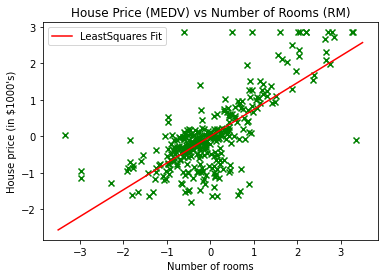

In [15]:
# visualizing Fit
plot_price_vs_rooms(X_tr,Y_tr)
plt.plot(num_rooms, estimated_prices, color='r', label='LeastSquares Fit')
_ = plt.legend()

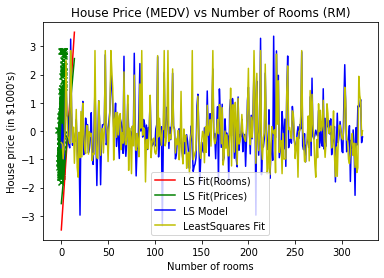

In [16]:
# TODO: additional analysis or plots. Discuss your results.
plot_price_vs_rooms(X_tr, Y_tr)
plt.plot(num_rooms, color="r", label="LS Fit(Rooms)")
plt.legend()

plt.plot(estimated_prices, color="g", label="LS Fit(Prices)")
plt.legend()

plt.plot(X_tr, color="b", label="LS Model ")
plt.legend()
plt.plot(Y_tr, color="y", label="LeastSquares Fit")
plt.legend()

plt.show()

###### I was unable to do what I wanted to here. I had an idea, but due to lack of time and inexperience I wasn't able to do it.

## Linear Regression with Multiple Variables

In this second task, you will be using more than feature to estimate house prices.
You could use 2, 4 or all the 13 features present in the dataset. You will have to analyse for yourself which features are contributing in correctly estimating housing prices. As an example, I would like to use crime rate and zoning information. Modify the list below as you please.

In [17]:
features = ["CRIM", "ZN"] # set your features here

### ==== TODO - 2 ====

Fill in the code for **LMS** class provided with this assignment (LeastMeanSquares.py)
1. complete **train_step** method
2. complete **train** method using train_step
3. complete **predict** method

In [18]:
from itcs4156.assignments.regression.LeastMeanSquares import LMS

X_tr, Y_tr = get_input_output(df_train, in_features=features, out_feature="MEDV")
X_val, Y_val = get_input_output(df_val, in_features=features, out_feature="MEDV")

In [19]:
# 2. Train model
alpha = 0.01 # Adjust your learning rate
model = LMS(alpha)
model.train(X_tr, Y_tr)

In [20]:
# 3. Evaluate Fit
evaluate(model, X_tr, Y_tr, X_val, Y_val)

Train MSE:  0.8614429141549681
Val MSE:  0.5774750863910545


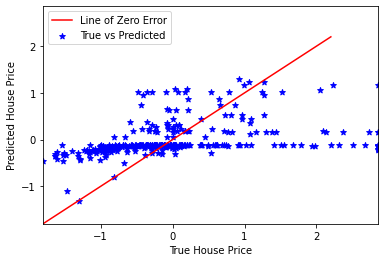

In [21]:
# 4. Visualize Predictions
def plot_true_vs_predicted(Y, pred):
    y1 = min(Y)
    y2 = max(Y)
    plt.scatter(Y, pred, label="True vs Predicted", color="b", marker="*")
    plt.xlabel("True House Price")
    plt.ylabel("Predicted House Price")
    plt.ylim(y1, y2)
    plt.xlim(y1, y2)
    I = np.arange(y1, y2)
    plt.plot(I, I, label="Line of Zero Error", color="r")
    plt.legend()
plot_true_vs_predicted(Y_tr, model.predict(X_tr))

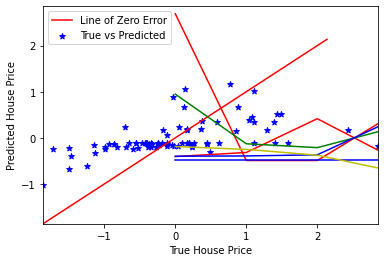

In [22]:
# TODO: additional analysis or plots. Discuss your results.
plot_true_vs_predicted(Y_val, model.predict(X_val))
plt.plot(X_tr, color="r", label="LMS Fit(CRIM)")

plt.plot(model.predict(X_tr), color="g", label="LS Fit(Prices)")

plt.plot(X_val, color="b", label="LS Model ")

plt.plot(Y_val, color="y", label="LeastSquares Fit")

plt.show()

###### Same as above, I was unable to do what I wanted to here. I had an idea, but due to lack of time and inexperience I wasn't able to do it.

## Polynomial Regression with One Variable

In this third task, *your mission, should you choose to accept it* is to fit a **polynomial model** for predicting house price just using the **LSTAT** feature.

In [23]:
X_tr, Y_tr = get_input_output(df_train, in_features="LSTAT", out_feature="MEDV")
X_val, Y_val = get_input_output(df_val, in_features="LSTAT", out_feature="MEDV")

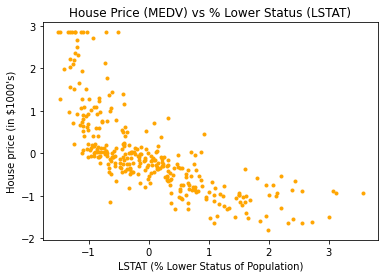

In [24]:
def plot_price_vs_LSTAT(X,Y):
    fig = plt.figure()
    plt.scatter(X, Y, marker='.', color='orange')
    plt.xlabel("LSTAT (% Lower Status of Population)")
    plt.ylabel("House price (in $1000's)")
    plt.title("House Price (MEDV) vs % Lower Status (LSTAT)")
plot_price_vs_LSTAT(X_tr,Y_tr)

### ==== TODO - 3 ====
Finish the code for **PolynomialSimple** class provided with this assigment.
- Fill in the code for **transform()** method
- The **PolynomialSimple** will reuse your *train()* and *predict()* methods from your **LeastSquares** class. So you don't need to implement them again.

In [25]:
from itcs4156.assignments.regression.PolynomialSimple import PolynomialSimple

In [26]:
# 1. Train
degree = 3  # adjust degree
model = PolynomialSimple(degree)
model.train(X_tr, Y_tr)

In [27]:
# 2. Evaluate Fit
evaluate(model, X_tr, Y_tr, X_val, Y_val)

Train MSE:  0.34931309127724486
Val MSE:  0.24063689850166656


In [28]:
# 3. Make some predictions
lstat = np.arange(-2,4,0.5).reshape((-1,1))
estimated_prices = model.predict(lstat)

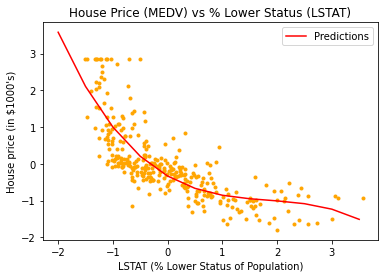

In [29]:
# 4. Visualize
plot_price_vs_LSTAT(X_tr,Y_tr)
plt.plot(lstat, estimated_prices, label='Predictions', color='r')
_  = plt.legend()

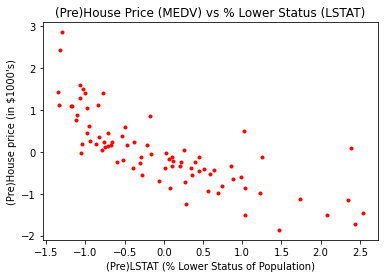

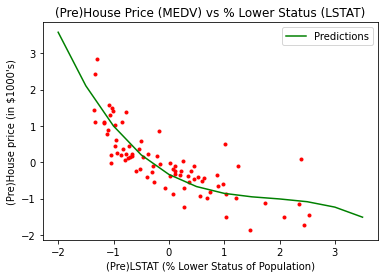

In [30]:
# TODO: additional analysis or plots. Discuss your results.
def plot_price_vs_LSTAT(X, Y):
    fig = plt.figure()
    plt.scatter(X, Y, marker=".", color="r")
    plt.xlabel("(Pre)LSTAT (% Lower Status of Population)")
    plt.ylabel("(Pre)House price (in $1000's)")
    plt.title("(Pre)House Price (MEDV) vs % Lower Status (LSTAT)")


plot_price_vs_LSTAT(X_val, Y_val)

plot_price_vs_LSTAT(X_val, Y_val)
plt.plot(lstat, estimated_prices, label="Predictions", color="g")
_ = plt.legend()

###### Before the model was applied, the data is fairly spead out, with minor clusters here and there that vaguely configure to the line. Shows how well the model training worked

## Polynomial Regression with Multiple Variables (+ Regularization)

In this final task, you will fit a polynomial model using multiple **features** just like you did in task 2. Additionally, you will make use of L2  regularization.


In [31]:
features = [
    "CRIM",
    "ZN",
    "DIS",
    "RM",
    "RAD",
    "INDUS",
    "AGE",
    "TAX",
    "LSTAT",
]  # select your features

### ==== TODO - 4 ====
Finish the code for **PolynomialRegression** class provided with this assignment (PolynomialMulti.py). This class also inherits from **LeastSquares** class but you will need to make the following changes:

1. Implement **transform()** method.
2. Re-implement **train()** method to include **regularization** term.
3. **Predict()** method remains same. No need to modify.

In [32]:
from itcs4156.assignments.regression.PolynomialMulti import PolynomialRegression

In [33]:
X_tr, Y_tr = get_input_output(df_train, in_features=features, out_feature="MEDV")
X_val, y_val = get_input_output(df_val, in_features=features, out_feature="MEDV")

In [34]:
# 1. Train
degree = 2  # adjust degree
lamb = 0.1  # adjust lambda
model = PolynomialRegression(degree, lamb)
model.train(X_tr, Y_tr)

(array([[ 1.00000000e+00,  1.00000000e+00, -4.05705738e-01, ...,
          1.72252131e-01,  1.33434969e-01,  1.03365287e-01],
        [ 1.00000000e+00,  1.00000000e+00, -3.17116563e-01, ...,
          3.25715253e-01, -2.39009256e-02,  1.75384554e-03],
        [ 1.00000000e+00,  1.00000000e+00,  4.15197985e-01, ...,
          2.60418962e+00,  2.43436824e+00,  2.27562107e+00],
        ...,
        [ 1.00000000e+00,  1.00000000e+00, -4.05218106e-01, ...,
          5.39790699e-05, -8.26953049e-03,  1.26688241e+00],
        [ 1.00000000e+00,  1.00000000e+00, -3.79396950e-01, ...,
          3.55054129e-03, -3.49512994e-03,  3.44058338e-03],
        [ 1.00000000e+00,  1.00000000e+00, -4.03149754e-01, ...,
          5.31325904e-01,  5.08591007e-01,  4.86828913e-01]]),
 array([[-0.05466534],
        [-0.05466534],
        [-0.37968505],
        [-0.03006378],
        [-0.169388  ],
        [ 0.41986629],
        [ 0.25147752],
        [ 0.48652483],
        [-0.13515099],
        [-0.25199013],

In [35]:
# 3. Evaluate Fit
evaluate(model, X_tr, Y_tr, X_val, Y_val)

Train MSE:  0.08818435850306137
Val MSE:  0.2060302088554819


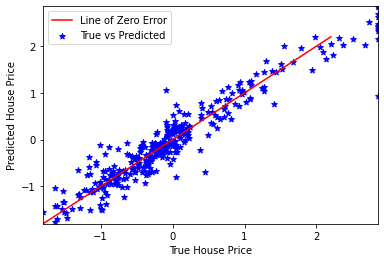

In [36]:
# 4. Plot predictions
plot_true_vs_predicted(Y_tr, model.predict(X_tr))

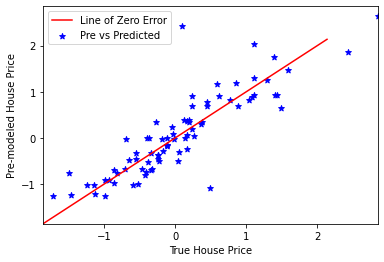

In [37]:
# TODO: additional analysis or plots. Discuss your results.
def plot_pre_vs_predicted(Y, pred):
    y1 = min(Y)
    y2 = max(Y)
    plt.scatter(Y, pred, label="Pre vs Predicted", color="b", marker="*")
    plt.xlabel("True House Price")
    plt.ylabel("Pre-modeled House Price")
    plt.ylim(y1, y2)
    plt.xlim(y1, y2)
    I = np.arange(y1, y2)
    plt.plot(I, I, label="Line of Zero Error", color="r")
    plt.legend()
plot_pre_vs_predicted(Y_val, model.predict(X_val))

###### This graph shows the model before it is trained. While not prefectly alined it shows that even before train the model had a basic shape that would allow for training a good model.

# Putting it All Together!

Once you have finished all the above four **TODOs** and you are satisfied with the  results you are getting, it is time evaluate all your code together and make it ready for submission.

### ==== TODO - 5 ====

Open the **train.py** given with this assignment and set the appropriate parameters (features, alpha, degree,lamb) for your models in the given functions.

## Final Testing

Next, we will evaluate all your models on the validation split. The test case will pass if your val mse is less than the alloted threshold. This only indicates that your model satisfies the minimum requirement. It also gives you an estimated score for this assignment. Your goal should be to strive for lower train and val MSE's and not just passing the test cases.

In [38]:
from itcs4156.assignments.regression.evaluate import eval
eval()

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\housing.train

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\housing.val

Skipping download. File already exists: c:\users\michael cowell\school projects\itcs-4156\programming-assignments\itcs4156\datasets\data\housing.names

Training:  LeastSquares
Evaluating:  LeastSquares
MSE: Train = 0.4603289264818989, Val = 0.5194255953697103
Is Val MSE < 0.6: True
Test PASSED! (っ＾▿＾)💨

Training:  LMS
Evaluating:  LMS
MSE: Train = 0.8614429141549681, Val = 0.5774750863910545
Is Val MSE < 0.9: True
Test PASSED! (っ＾▿＾)💨

Training:  PolynomialSimple
Evaluating:  PolynomialSimple
MSE: Train = 0.34931309127724486, Val = 0.24063689850166656
Is Val MSE < 0.3: True
Test PASSED! (っ＾▿＾)💨

Training:  PolynomialRegression
Evaluating:  PolynomialRegression
MSE: Train = 0.08818435850306

# Grading 


The final grading will be done on **TEST** dataset when you submit this assignment on **Autolab**. 

Points | Description
--|--------:
20 | LeastSquares
20 | LMS
20 | PolynomialSimple
20 | PolynomialRegression
10 | Analysis of the problem and the results presented by you in this notebook.
10 | $\frac{(N - R + 1)}{N} \times 10$

The last 10 points will be calculated based on your rank (R) among all students (N). The rank will be computed based on your average **test** MSE's. It will be visible to you (and anonymous to others) in leaderboard on Autolab as you make submissions.  

# Submission


```
| - itcs4156
    | - assignments
        | - regression   <----------- Zip this folder and submit on AutoLab
            | - train.py
            | - LeastMeanSquares.py
            | - LeastSquares.py
            | - PolynomialSimple.py
            | - PolynomailMulti.py
            | - evaluate.py
            | - __init__.py
    | - notebooks
        | - 1 - LinearRegression.ipynb <----- Upload this file on Canvas
```